In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [2]:
df = pd.read_csv('df_short_1_target.csv')

In [3]:
df_train_val, df_test = train_test_split(df, test_size=0.1, shuffle=True)

In [4]:
df.shape

(54510, 25)

In [5]:
y = df_train_val.Price
X = df_train_val.drop(['Price'], axis=1)

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)
categorical_cols = [cname for cname in X_train_full.columns if 
                        X_train_full[cname].dtype == "object"]

numerical_cols = [cname for cname in X_train_full.columns if df[cname].dtype in ['int64', 'float64','int32']]

my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [6]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label', OneHotEncoder())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [7]:
from lightgbm import LGBMRegressor

model = ExtraTreesRegressor(n_jobs=-1)

In [8]:
from sklearn.metrics import mean_absolute_error, r2_score,median_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = median_absolute_error(y_valid, preds)
print('MAE:', score)


MAE: 50578.685000000056


In [9]:
comparison = y_valid.to_frame()

In [10]:
comparison['Prediction'] = preds.tolist()

In [11]:
comparison['error_percentage'] = (comparison.Prediction - comparison.Price)/comparison.Price * 100

(array([5.000e+00, 8.000e+00, 3.100e+01, 1.560e+02, 1.278e+03, 6.235e+03,
        1.658e+03, 2.820e+02, 8.000e+01, 3.500e+01]),
 array([-90.59759474, -74.04324235, -57.48888995, -40.93453756,
        -24.38018517,  -7.82583278,   8.72851961,  25.28287201,
         41.8372244 ,  58.39157679,  74.94592918]),
 <BarContainer object of 10 artists>)

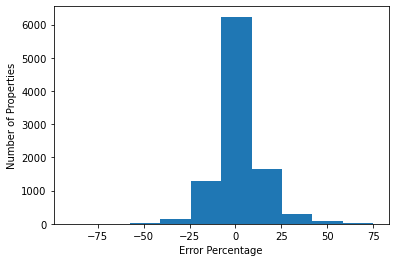

In [15]:
plt.xlabel('Error Percentage')
plt.ylabel('Number of Properties')
plt.hist(comparison[comparison['error_percentage']<75]['error_percentage'])

In [16]:
comparison.error_percentage.abs().mean()

9.215696224238215

In [15]:
comparison.to_csv('comparison.csv')

In [48]:
df_train_val.to_csv('df_short_train_val.csv', index=False)

In [49]:
df_test.to_csv('df_short_test.csv', index=False)

In [39]:
import pickle

pickle.dump(my_pipeline, open('data_3_model_3','wb'))
